In [13]:
import numpy as np
from lattice_class import *
import scipy.linalg
import matplotlib.pyplot as plt

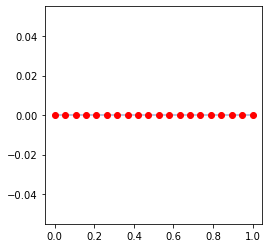

In [56]:
N = 20
lattice = ChainLattice(N, "open")
lattice.plot()
num_sites = lattice.get_num_nodes()

lattice_sites = lattice.get_nodes()
lattice_edges = lattice.get_edges()
reciprocal_lattice_sites = lattice.get_reciprocal_nodes()


Energies =  [-1.63916424e+00 -1.63916424e+00 -1.60692400e+00 -1.60692400e+00
 -1.55407737e+00 -1.55407737e+00 -1.48194520e+00 -1.48194520e+00
 -1.39236010e+00 -1.39236010e+00 -1.28765791e+00 -1.28765791e+00
 -1.17068175e+00 -1.17068175e+00 -1.04481807e+00 -1.04481807e+00
 -9.14104936e-01 -9.14104936e-01 -7.83499588e-01 -7.83499588e-01
 -6.59526671e-01 -6.59526671e-01 -5.52803020e-01 -5.52803020e-01
 -5.42422106e-01 -5.42422106e-01 -5.17995632e-01 -5.17995632e-01
 -4.92338194e-01 -4.92338194e-01 -4.60715647e-01 -4.60715647e-01
 -4.50060078e-01 -4.50060078e-01 -4.12135899e-01 -4.12135899e-01
 -4.11766997e-01 -4.11766997e-01 -5.64042717e-05 -5.64042717e-05
  5.64042717e-05  5.64042717e-05  4.11766997e-01  4.11766997e-01
  4.12135899e-01  4.12135899e-01  4.50060078e-01  4.50060078e-01
  4.60715647e-01  4.60715647e-01  4.92338194e-01  4.92338194e-01
  5.17995632e-01  5.17995632e-01  5.42422106e-01  5.42422106e-01
  5.52803020e-01  5.52803020e-01  6.59526671e-01  6.59526671e-01
  7.83499588e

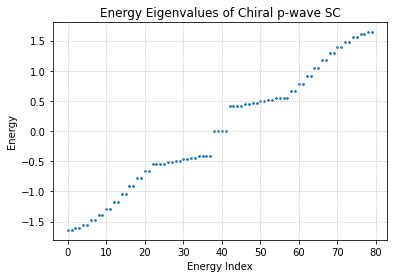

In [57]:
mu          = -0.5
delta       = complex(0.5, 0.0)

H_k         = lambda k: np.array(
                                [[-(np.cos(k[0]) + np.cos(k[1])) - mu,                                 0.0], 
                                 [                                0.0, -(np.cos(k[0]) + np.cos(k[1])) - mu]]
                                , dtype=complex)
gap_fct     = lambda k: np.array(
                                [[                                                   0.0, delta * complex(np.sin(k[0]), np.sin(k[1]))], 
                                 [delta.conjugate()*complex(np.sin(k[0]), -np.sin(k[1])),                                         0.0]]
                                , dtype=complex)
H_BdG       = lambda k: np.block(
                                [[             H_k(k),      gap_fct(k)], 
                                 [gap_fct(k).conj().T, -H_k(-k).conj()]]
                                )
dim_H_BdG = 4

def get_H_tilde(direction, axis=0):
    H_tilde = np.zeros(shape=(dim_H_BdG, dim_H_BdG), dtype=complex)
    for k in reciprocal_lattice_sites:
        H_tilde += 1.0 / num_sites * H_BdG(np.array(k)) * np.exp(direction * complex(0.0, 1.0) * k[axis])
    return H_tilde

H_direct_lattice = np.zeros(shape=(num_sites * dim_H_BdG, num_sites * dim_H_BdG), dtype=complex)
block_indices = [slice(block_idx * dim_H_BdG, (block_idx+1) * dim_H_BdG) for block_idx in range(lattice.get_num_nodes())]

for (node_idx, node) in enumerate(lattice.get_nodes()):
    H_direct_lattice[block_indices[node_idx], block_indices[node_idx]] = get_H_tilde(0)

    for neighbour_idx in lattice_edges[node_idx]:
        axis = -1 
        if (neighbour_idx) // N != (node_idx // N):
            axis = 1
        elif (neighbour_idx) // N == (node_idx // N):
            axis = 0
        else:
            print("something went terribly wrong while constructing the direct lattice hamiltonian")
        assert axis == 0 or axis == 1, "axis assertion failed"

        direction = 0
        if node_idx < neighbour_idx:
            direction = (-1)**axis
        elif node_idx > neighbour_idx:
            direction = -1 * (-1)** axis
        else:
            print("something went terribly wrong while constructing the direct lattice hamiltonian")
        assert direction == 1 or direction == -1, "direction assertion failed"

        # print("Node {} has neighbour {} along axis {} in direction {}".format(node_idx, neighbour_idx, axis, direction))

        H_direct_lattice[block_indices[node_idx], block_indices[neighbour_idx]] = get_H_tilde(direction, axis)

energies, states = scipy.linalg.eigh(H_direct_lattice)
print("Energies = ", energies)
print("Lowest found energy: ", np.min(np.abs(energies)))
gs_idx = np.argmin(np.abs(energies))
print("Index of lowest absolute energy: ", gs_idx)

plt.xlabel("Energy Index")
plt.ylabel("Energy")
plt.grid(linestyle=":")
plt.title("Energy Eigenvalues of Chiral p-wave SC")
plt.scatter(range(len(energies)), energies, s=3)

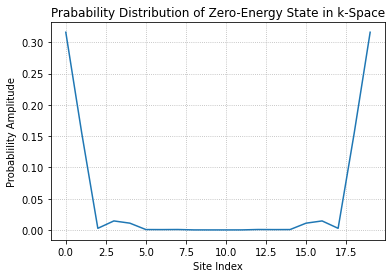

In [58]:
gs_wave_function = states[:, gs_idx]
gs_probabilities_nambu = np.square(np.abs(gs_wave_function))
gs_probabilities = np.zeros(shape=(num_sites, 1))

for site_idx in range(num_sites):
    gs_probabilities[site_idx] = np.sum(gs_probabilities_nambu[block_indices[site_idx]])

for node in lattice.get_nodes():
    gs_probabilities


plt.xlabel("Site Index")
plt.ylabel("Probablility Amplitude")
plt.title("Prabability Distribution of Zero-Energy State in k-Space")
plt.grid(linestyle=':')
plt.plot(range(num_sites), gs_probabilities)

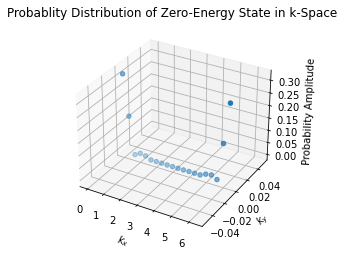

In [59]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
kx_values = [k[0] for k in reciprocal_lattice_sites]
ky_values = [k[1] for k in reciprocal_lattice_sites]

plt.grid(linestyle=":")
ax.set_xlabel(r"$k_{x}$")
ax.set_ylabel(r"$k_{y}$")
ax.set_zlabel("Probability Amplitude")
ax.set_title("Probablity Distribution of Zero-Energy State in k-Space")
ax.scatter(kx_values, ky_values, gs_probabilities)